# Predykcja wystąpienia szkody z wykorzystaniem wybranych algorytmów uczenia maszynowego

## OPIS I ANALIZA WYKORZYSTANYCH DANYCH

### Ładowanie bibliotek

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression

### Wczytywanie danych

In [39]:
df = pd.read_csv("C:/Python/Motor vehicle insurance data.csv", sep = ';')
print(df.shape)
print(df.head())
print(df.dtypes)

(105555, 30)
   ID Date_start_contract Date_last_renewal Date_next_renewal  Date_birth  \
0   1          05/11/2015        05/11/2015        05/11/2016  15/04/1956   
1   1          05/11/2015        05/11/2016        05/11/2017  15/04/1956   
2   1          05/11/2015        05/11/2017        05/11/2018  15/04/1956   
3   1          05/11/2015        05/11/2018        05/11/2019  15/04/1956   
4   2          26/09/2017        26/09/2017        26/09/2018  15/04/1956   

  Date_driving_licence  Distribution_channel  Seniority  Policies_in_force  \
0           20/03/1976                     0          4                  1   
1           20/03/1976                     0          4                  1   
2           20/03/1976                     0          4                  2   
3           20/03/1976                     0          4                  2   
4           20/03/1976                     0          4                  2   

   Max_policies  ...  Area  Second_driver Year_matricul

### Konwersja zmiennych dotyczących dat na odpowiedni format

In [40]:
df['Date_start_contract'] = pd.to_datetime(df['Date_start_contract'], dayfirst=True)
df['Date_last_renewal'] = pd.to_datetime(df['Date_last_renewal'], dayfirst=True)
df['Date_next_renewal'] = pd.to_datetime(df['Date_next_renewal'], dayfirst=True)
df['Date_birth'] = pd.to_datetime(df['Date_birth'], dayfirst=True)
df['Date_driving_licence'] = pd.to_datetime(df['Date_driving_licence'], dayfirst=True)
df['Date_lapse'] = pd.to_datetime(df['Date_lapse'], dayfirst=True)

### Zatrzymanie jedynie najaktualniejszych rekordów

In [41]:
df = df.loc[df.groupby('ID')['Date_next_renewal'].idxmax()]

df = df.reset_index(drop=True)

### Tworzenie nowych zmiennych

In [42]:
# 'Age' - wiek ubezpieczonego (rocznikowo) 
df['Age'] = df['Date_next_renewal'].dt.year - df['Date_birth'].dt.year

# 'Driver_pass_exam_yr' - wiek otrzymania prawa jazdy
df['Driver_pass_exam_yr'] = df['Date_driving_licence'].dt.year - df['Date_birth'].dt.year

# 'Min_one_policy_lapsed' - czy zerwano przynajmniej jedną polisę
df['Min_one_policy_lapsed'] = df['Date_lapse'].isna().astype(int)

# 'Vehicle_age' - wiek samochodu (rocznikowo)
df['Vehicle_age'] = df['Date_next_renewal'].dt.year - df['Year_matriculation']

# 'Cost_claims_year' -> 'Is_claim' - zamiana nazwy kolumny i odpowiednie kodowanie (zmienna zależna)
df = df.rename(columns={'Cost_claims_year': 'Is_claim'})
df['Is_claim'] = (df['Is_claim'] > 0).astype(int)

### Usuwanie zbędnych zmiennych

In [43]:
df = df.drop(columns = ['ID', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal', 'Date_birth', 'Date_driving_licence', 'Lapse', 'Date_lapse', 'N_claims_year', 'R_Claims_history', 'Year_matriculation'])

### Konwersja zmiennych na odpowiedni format

In [44]:
df.dtypes

Distribution_channel       int64
Seniority                  int64
Policies_in_force          int64
Max_policies               int64
Max_products               int64
Payment                    int64
Premium                  float64
Is_claim                   int32
N_claims_history           int64
Type_risk                  int64
Area                       int64
Second_driver              int64
Power                      int64
Cylinder_capacity          int64
Value_vehicle            float64
N_doors                    int64
Type_fuel                 object
Length                   float64
Weight                     int64
Age                        int32
Driver_pass_exam_yr        int32
Min_one_policy_lapsed      int32
Vehicle_age                int64
dtype: object

In [45]:
df['Is_claim'] = df['Is_claim'].astype('int64')
df['Age'] = df['Age'].astype('int64')
#df['Driver_experience'] = df['Driver_experience'].astype('int64')
df['Driver_pass_exam_yr'] = df['Driver_pass_exam_yr'].astype('int64')
df['Min_one_policy_lapsed'] = df['Min_one_policy_lapsed'].astype('int64')
df['Type_risk'] = df['Type_risk'].astype('object')

In [46]:
df.dtypes

Distribution_channel       int64
Seniority                  int64
Policies_in_force          int64
Max_policies               int64
Max_products               int64
Payment                    int64
Premium                  float64
Is_claim                   int64
N_claims_history           int64
Type_risk                 object
Area                       int64
Second_driver              int64
Power                      int64
Cylinder_capacity          int64
Value_vehicle            float64
N_doors                    int64
Type_fuel                 object
Length                   float64
Weight                     int64
Age                        int64
Driver_pass_exam_yr        int64
Min_one_policy_lapsed      int64
Vehicle_age                int64
dtype: object

### Weryfikacja brakujących wartości w zbiorze danych

In [47]:
print(df.isnull().sum())

Distribution_channel        0
Seniority                   0
Policies_in_force           0
Max_policies                0
Max_products                0
Payment                     0
Premium                     0
Is_claim                    0
N_claims_history            0
Type_risk                   0
Area                        0
Second_driver               0
Power                       0
Cylinder_capacity           0
Value_vehicle               0
N_doors                     0
Type_fuel                 857
Length                   5142
Weight                      0
Age                         0
Driver_pass_exam_yr         0
Min_one_policy_lapsed       0
Vehicle_age                 0
dtype: int64


### Imputacja brakujących wartości dla zmiennej 'Length' za pomocą regresji liniowej

In [48]:
correlations = df.corr(numeric_only=True)['Length'].sort_values(ascending=False)
print(correlations)

Length                   1.000000
Weight                   0.830984
Cylinder_capacity        0.633176
Value_vehicle            0.605769
Power                    0.464250
Premium                  0.190552
Max_policies             0.087341
N_claims_history         0.078616
Policies_in_force        0.077022
Is_claim                 0.056154
Distribution_channel     0.041913
Payment                  0.031633
Max_products             0.014742
Age                      0.012301
N_doors                  0.011920
Min_one_policy_lapsed    0.009915
Area                    -0.009252
Seniority               -0.042299
Driver_pass_exam_yr     -0.052145
Vehicle_age             -0.072767
Second_driver           -0.081515
Name: Length, dtype: float64


In [49]:
X_known = df[df['Length'].notna()]
X_missing = df[df['Length'].isna()]

# Dobra korelacja ze zmiennymi 'Weight' oraz 'Cylinder_capacity'
features = ['Weight', 'Cylinder_capacity']

model = LinearRegression()
model.fit(X_known[features], X_known['Length'])

predicted_lengths = model.predict(X_missing[features])

df.loc[df['Length'].isna(), 'Length'] = predicted_lengths

### Imputacja brakujących wartości dla zmiennej 'Type_fuel' za pomocą wartości 'Unknown'

In [50]:
df['Type_fuel'] = df['Type_fuel'].fillna('Unknown')

### Podstawowe statystyki opisowe zmiennych

In [51]:
df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Distribution_channel,53502.0,0.48,0.50,0.00,0.00,0.00,1.00,1.00
Seniority,53502.0,5.79,5.91,1.00,2.00,4.00,7.00,40.00
Policies_in_force,53502.0,1.51,1.03,1.00,1.00,1.00,2.00,17.00
Max_policies,53502.0,1.86,1.22,1.00,1.00,2.00,2.00,17.00
Max_products,53502.0,1.06,0.26,1.00,1.00,1.00,1.00,4.00
Payment,53502.0,0.34,0.47,0.00,0.00,0.00,1.00,1.00
Premium,53502.0,320.05,144.10,40.18,242.81,295.71,367.40,2596.77
Is_claim,53502.0,0.11,0.31,0.00,0.00,0.00,0.00,1.00
N_claims_history,53502.0,2.61,3.83,0.00,0.00,1.00,4.00,52.00
Area,53502.0,0.27,0.45,0.00,0.00,0.00,1.00,1.00


### Badanie rozkładu zmiennej zależnej 'Is_claim'

Rozkład zmiennej zależnej: Counter({0: 47552, 1: 5950})


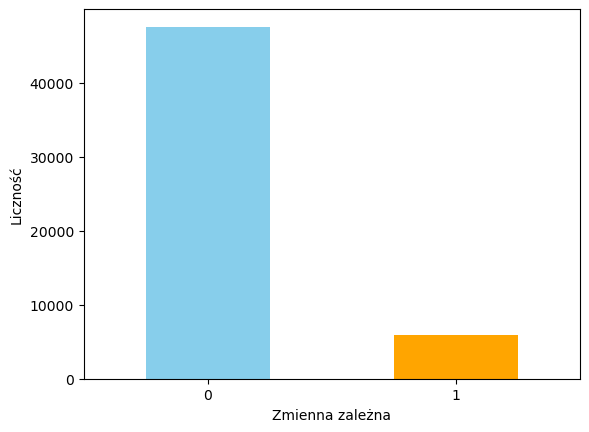

In [52]:
print("Rozkład zmiennej zależnej:", Counter(df['Is_claim']))

pd.Series(df['Is_claim']).value_counts().sort_index().plot(
    kind='bar',
    color=['skyblue', 'orange']
)

plt.xlabel("Zmienna zależna")
plt.ylabel("Liczność")
plt.xticks(rotation=0)
plt.title("")
plt.show()

### Rozdzielenie danych na zmienne niezależne i zmienną zależną

In [53]:
X = df.drop(columns=['Is_claim'])
y = df["Is_claim"]

### Podział na zbiór treningowy i testowy

In [54]:
# Proporcje: 80% - zbiór uczący; 20% zbiór testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## REGRESJA LOGISTYCZNA

### Kodowanie zmiennych ilościowych i jakościowych (pierwszy model)

In [55]:
categorical_cols_lr = [
    col for col in X_train.columns
    if X_train[col].dtype == "object"
]

numerical_cols_lr = [
    col for col in X_train.columns
    if X_train[col].dtype in ["int64", "float64"]
]

preprocessor_lr = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop='first', handle_unknown="ignore", sparse_output=False), categorical_cols_lr),
        ("num", StandardScaler(), numerical_cols_lr)
    ]
)

### Budowa i ocena pierwszego modelu

In [56]:
model_lr = Pipeline([
    ("preprocessing", preprocessor_lr),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        random_state=42,
    ))
])

model_lr.fit(X_train, y_train)

y_pred_lr = model_lr.predict(X_test)

print("Regresja logistyczna (pierwszy model):\n", classification_report(y_test, y_pred_lr))

Regresja logistyczna (pierwszy model):
               precision    recall  f1-score   support

           0       0.96      0.78      0.86      9511
           1       0.30      0.77      0.44      1190

    accuracy                           0.78     10701
   macro avg       0.63      0.77      0.65     10701
weighted avg       0.89      0.78      0.81     10701



### Badanie współliniowości

In [57]:
numeric_df = X_train.select_dtypes(include=[np.number])

corr_matrix = numeric_df.corr().abs()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

print("Do usunięcia:", to_drop)

X_train_lr = X_train.drop(columns=to_drop)

Do usunięcia: ['Weight']


### Usuwanie Outliers w zmiennych ilościowych

In [58]:
X_train_lr.shape

(42801, 21)

In [59]:
def remove_outliers_iqr_Xy(X, y, columns):
    
    X_ = X.copy()
    y_ = y.copy()

    mask = pd.Series([True] * X_.shape[0], index=X_.index)

    for col in columns:
        Q1 = X_[col].quantile(0.25)
        Q3 = X_[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 +  1.5 * IQR
        mask &= X_[col].between(lower_bound, upper_bound)

    return X_[mask], y_[mask]

numerical_cols_lr2 = [
    col for col in X_train_lr.columns
    if X_train_lr[col].dtype in ["float64"]
]

X_train_lr, y_train_lr = remove_outliers_iqr_Xy(X_train_lr, y_train, numerical_cols_lr2)

print("Po usunięciu Outliers:", X_train_lr.shape)

Po usunięciu Outliers: (34760, 21)


### Kodowanie zmiennych ilościowych i jakościowych (drugi model)

In [60]:
categorical_cols_lr2 = [
    col for col in X_train_lr.columns
    if X_train_lr[col].dtype == "object"
]

numerical_cols_lr2 = [
    col for col in X_train_lr.columns
    if X_train_lr[col].dtype in ["int64", "float64"]
]

preprocessor_lr2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop = 'first', handle_unknown="ignore", sparse_output=True), categorical_cols_lr2),
        ("num", StandardScaler(), numerical_cols_lr2)
    ]
)

### Budowa i ocena drugiego modelu

In [61]:
model_lr2 = Pipeline([
    ("preprocessing", preprocessor_lr2),
    ("smote", SMOTE(random_state=42)),
    ("classifier", LogisticRegression(
        class_weight='balanced',
        max_iter=2000,
        random_state=42,
    ))
])

model_lr2.fit(X_train_lr, y_train_lr)

y_pred_lr2 = model_lr2.predict(X_test)

print("Regresja logistyczna (drugi model):\n", classification_report(y_test, y_pred_lr2))

Regresja logistyczna (drugi model):
               precision    recall  f1-score   support

           0       0.96      0.79      0.87      9511
           1       0.31      0.75      0.44      1190

    accuracy                           0.79     10701
   macro avg       0.64      0.77      0.65     10701
weighted avg       0.89      0.79      0.82     10701



### Współczynniki i badanie ich istotności dla pierwszego modelu regresji logistycznej

In [62]:
X_processed = model_lr.named_steps["preprocessing"].transform(X_train)
X_resampled, y_resampled = model_lr.named_steps["smote"].fit_resample(X_processed, y_train)

X_resampled_const = sm.add_constant(X_resampled)

model_sm = sm.Logit(y_resampled, X_resampled_const)
results = model_sm.fit(method='lbfgs', maxiter=1000)

feature_names_cat = model_lr.named_steps["preprocessing"].named_transformers_["cat"].get_feature_names_out(categorical_cols_lr)
feature_names_num = numerical_cols_lr
feature_names_all = ["Intercept"] + list(model_lr.named_steps["preprocessing"].get_feature_names_out())

df_results = pd.DataFrame({
    "Zmienna": feature_names_all,
    "Współczynnik": results.params,
    "p-value": results.pvalues,
})

df_results_sorted = df_results.sort_values(by="p-value", ascending=True, na_position='last')

print(df_results_sorted)

                          Zmienna  Współczynnik        p-value
x13         num__N_claims_history      1.739716   0.000000e+00
x7                 num__Seniority     -1.463850   0.000000e+00
x9              num__Max_policies     -0.812899  1.203444e-292
x8         num__Policies_in_force      0.689644  3.959870e-257
x11                  num__Payment      0.178424   4.331335e-93
x24    num__Min_one_policy_lapsed      0.176811   2.554931e-83
x22                      num__Age     -0.133837   8.858461e-41
const                   Intercept     -0.848846   3.207180e-25
x23      num__Driver_pass_exam_yr      0.081842   2.679788e-19
x15            num__Second_driver      0.070076   1.686715e-16
x4               cat__Type_fuel_P     -0.166136   4.294721e-13
x6      num__Distribution_channel      0.053528   2.490728e-09
x12                  num__Premium     -0.047883   3.598741e-06
x20                   num__Length      0.128260   3.680726e-06
x19                  num__N_doors      0.079048   4.216

## DRZEWA DECYZYJNE

### Kodowanie zmiennych ilościowych i jakościowych (pierwszy model)

In [63]:
categorical_cols_dt = [
    col for col in X_train.columns
    if X_train[col].dtype == "object"
]

numerical_cols_dt = [
    col for col in X_train.columns
    if X_train[col].dtype in ["int64", "float64"]
]

preprocessor_dt = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols_lr),
        ("num", "passthrough", numerical_cols_dt)
    ]
)

### Budowa i ocena pierwszego modelu

In [64]:
model_dt = Pipeline([
    ("preprocessing", preprocessor_dt),
    ("smote", SMOTE(random_state=42)),
    ("classifier", DecisionTreeClassifier(
        random_state=42
    ))
])

model_dt.fit(X_train, y_train)

y_pred_dt = model_dt.predict(X_test)
print("Drzewo decyzyjne (pierwszy model):\n", classification_report(y_test, y_pred_dt))

Drzewo decyzyjne (pierwszy model):
               precision    recall  f1-score   support

           0       0.93      0.92      0.92      9511
           1       0.39      0.44      0.41      1190

    accuracy                           0.86     10701
   macro avg       0.66      0.68      0.67     10701
weighted avg       0.87      0.86      0.87     10701



### Optymalizacja hiperparametrów, budowa i ocena drugiego modelu

In [65]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__max_depth': [5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10, 20],
    'classifier__min_samples_leaf': [1, 2, 4, 10],
    'classifier__criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(model_dt, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

model_dt2 = grid_search.best_estimator_
y_pred_best = model_dt2.predict(X_test)
model_dt2 = grid_search.best_estimator_
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      9511
           1       0.51      0.49      0.50      1190

    accuracy                           0.89     10701
   macro avg       0.72      0.71      0.72     10701
weighted avg       0.89      0.89      0.89     10701



In [66]:
print("Najlepsze hiperparametry:")
print(grid_search.best_params_)

Najlepsze hiperparametry:
{'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}


### Wizualizacja drzewa decyzyjnego (drugi model)

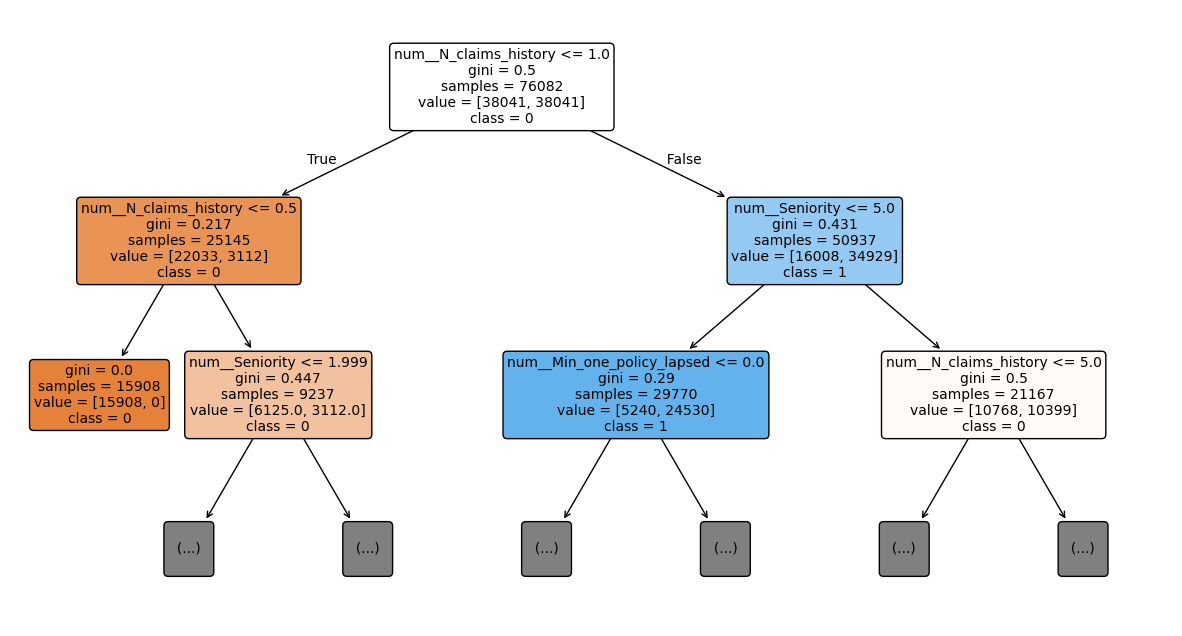

In [67]:
plt.figure(figsize=(15, 8))
plot_tree(
    model_dt2.named_steps['classifier'],
    filled=True,
    rounded=True,
    feature_names=model_dt2.named_steps["preprocessing"].get_feature_names_out(),
    class_names=sorted(y_train.unique().astype(str)),
    fontsize=10,
    max_depth=2
)
plt.show()

## NAIWNY KLASYFIKATOR BAYESA

### Kodowanie zmiennych ilościowych i jakościowych (pierwszy model)

In [68]:
categorical_cols_nb = [
    col for col in X_train.columns
    if X_train[col].dtype == "object"
]

numerical_cols_nb = [
    col for col in X_train.columns
    if X_train[col].dtype in ["int64", "float64"]
]

preprocessor_nb = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols_nb),
        ("num", "passthrough", numerical_cols_nb)
    ]
)

### Budowa i ocena pierwszego modelu

In [69]:
model_nb = Pipeline(steps=[
    ('preprocessing', preprocessor_nb),
    ("smote", SMOTE(random_state=42)),
    ('classifier', GaussianNB())
])

model_nb.fit(X_train, y_train)

y_pred_nb = model_nb.predict(X_test)
print("Naiwny klasyfikator Bayesa (pierwszy model):\n", classification_report(y_test, y_pred_nb))

Naiwny klasyfikator Bayesa (pierwszy model):
               precision    recall  f1-score   support

           0       0.94      0.38      0.54      9511
           1       0.14      0.82      0.24      1190

    accuracy                           0.43     10701
   macro avg       0.54      0.60      0.39     10701
weighted avg       0.85      0.43      0.50     10701



### Kodowanie zmiennych ilościowych i jakościowych (drugi model)

In [70]:
categorical_cols_nb2 = [
    col for col in X_train_lr.columns
    if X_train_lr[col].dtype == "object"
]

numerical_cols_nb2 = [
    col for col in X_train_lr.columns
    if X_train_lr[col].dtype in ["int64", "float64"]
]

preprocessor_nb2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical_cols_nb2),
        ("num", "passthrough", numerical_cols_nb2)
    ]
)

### Budowa drugiego modelu

In [71]:
model_nb2 = Pipeline(steps=[
    ('preprocessing', preprocessor_nb2),
    ("smote", SMOTE(random_state=42)),
    ('classifier', GaussianNB())
])

model_nb2.fit(X_train_lr, y_train_lr)

y_pred_nb2 = model_nb2.predict(X_test)
print("Naiwny klasyfikator Bayesa (drugi model):\n", classification_report(y_test, y_pred_nb2))

Naiwny klasyfikator Bayesa (drugi model):
               precision    recall  f1-score   support

           0       0.93      0.67      0.78      9511
           1       0.18      0.58      0.27      1190

    accuracy                           0.66     10701
   macro avg       0.55      0.62      0.53     10701
weighted avg       0.84      0.66      0.72     10701

